# Challenge 2

### Mapping your data

### The netcdf files can be read in Python using the netcdf4 library

In [1]:
import netCDF4 as nc4

### Next, let’s read the file in:

In [2]:
from netCDF4 import Dataset
import numpy as np

my_example_nc_file = 'S5P_OFFL_L2__NO2____20220909T224800_20220910T002929_25432_03_020400_20220911T144137.nc'
fh = Dataset(my_example_nc_file, mode='r')
print (fh)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7
    institution: KNMI
    source: Sentinel 5 precursor, TROPOMI, space-borne remote sensing, L2
    summary: TROPOMI/S5P NO2 1-Orbit L2 Swath 5.5x3.5km
    tracking_id: 3e729247-9281-42b7-986a-15f0143ec799
    id: S5P_OFFL_L2__NO2____20220909T224800_20220910T002929_25432_03_020400_20220911T144137
    time_reference: 2022-09-09T00:00:00Z
    time_reference_days_since_1950: 26549
    time_reference_julian_day: 2459831.5
    time_reference_seconds_since_1970: 1662681600
    time_coverage_start: 2022-09-09T23:09:34Z
    time_coverage_end: 2022-09-10T00:07:58Z
    time_coverage_duration: PT3503.560S
    time_coverage_resolution: PT0.840S
    orbit: 25432
    references: http://www.tropomi.eu/data-products/nitrogen-dioxide https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-5p/products-algorithms
    processor_version: 2.4.0
    keywords_vocabulary: AGU index terms

### Print (fh) to see if the file has been loaded. This should return a lot of information about the file, such as when it was acquired, what sensor and its version, among many other things.

#### Next, let’s drill into the data.

In [3]:
print (fh.groups)

print (fh.groups['PRODUCT'])


{'PRODUCT': <class 'netCDF4._netCDF4.Group'>
group /PRODUCT:
    dimensions(sizes): scanline(4172), ground_pixel(450), corner(4), time(1), polynomial_exponents(6), intensity_offset_polynomial_exponents(1), layer(34), vertices(2)
    variables(dimensions): int32 scanline(scanline), int32 ground_pixel(ground_pixel), int32 time(time), int32 corner(corner), int32 polynomial_exponents(polynomial_exponents), int32 intensity_offset_polynomial_exponents(intensity_offset_polynomial_exponents), int32 layer(layer), int32 vertices(vertices), float32 latitude(time, scanline, ground_pixel), float32 longitude(time, scanline, ground_pixel), int32 delta_time(time, scanline), <class 'str'> time_utc(time, scanline), uint8 qa_value(time, scanline, ground_pixel), float32 nitrogendioxide_tropospheric_column(time, scanline, ground_pixel), float32 nitrogendioxide_tropospheric_column_precision(time, scanline, ground_pixel), float32 nitrogendioxide_tropospheric_column_precision_kernel(time, scanline, ground_pix

### By printing the fh.groups we can find the groups in the data, which are called ‘PRODUCT’ and ‘METADATA’. By printing fh.groups[‘PRODUCT’] we find the product has data about the dimension and variables.

In [4]:
print (fh.groups['PRODUCT'].variables.keys())

#By printing the .variables.keys() we can see that this .nc file has the following variables:

dict_keys(['scanline', 'ground_pixel', 'time', 'corner', 'polynomial_exponents', 'intensity_offset_polynomial_exponents', 'layer', 'vertices', 'latitude', 'longitude', 'delta_time', 'time_utc', 'qa_value', 'nitrogendioxide_tropospheric_column', 'nitrogendioxide_tropospheric_column_precision', 'nitrogendioxide_tropospheric_column_precision_kernel', 'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_total', 'tm5_tropopause_layer_index', 'tm5_constant_a', 'tm5_constant_b'])


In [5]:
#If we select one of these variables, say the ‘nitrogendioxide_tropospheric_column_precision’ using this command…

print (fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'])

#…we will finally get information about the data itself. You will see that the data has a value called current shape which we can convert into a numpy array.

<class 'netCDF4._netCDF4.Variable'>
float32 nitrogendioxide_tropospheric_column_precision(time, scanline, ground_pixel)
    units: mol m-2
    standard_name: troposphere_mole_content_of_nitrogen_dioxide standard_error
    long_name: Precision of the tropospheric vertical column of nitrogen dioxide
    coordinates: longitude latitude
    multiplication_factor_to_convert_to_molecules_percm2: 6.022141e+19
    _FillValue: 9.96921e+36
path = /PRODUCT
unlimited dimensions: 
current shape = (1, 4172, 450)
filling on


### Next we are taking the latitude, longtitude and no2 values which we will map.

In [6]:
lons = fh.groups['PRODUCT'].variables['longitude'][:][0,:,:]
lats = fh.groups['PRODUCT'].variables['latitude'][:][0,:,:]
no2 = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'][0,:,:]
print (lons.shape)
print (lats.shape)
print (no2.shape)

(4172, 450)
(4172, 450)
(4172, 450)


In [7]:
no2_units = fh.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column_precision'].units
# this line gets the units of NO2 so we can add it to the plot later on

### To plot map we are using 'Basemap' library follow the below procedure
### Install 'Basemap library'

In [8]:
#Install basemap in anaconda environment (As installation through conda's default channel conflicts with python 3 so we use forge channel, more details: https://stackoverflow.com/questions/35716830/basemap-with-python-3-5-anaconda-on-windows)
#conda install -c conda-forge basemap

#OR

#python -m pip install basemap 
#for more information check-https://pypi.org/project/basemap/

In [9]:
##If KeyError: 'PROJ_LIB' 
#Tell basemap where Proj4's "epsg" file is, to succeed , follow steps as follows

#For Windows user
import os
os.environ['PROJ_LIB'] = r'C:\\Users\\Aditya\\anaconda3\\envs\\GEODACenv'

#On a Mac, Anaconda is installed in a slightly different place: prefix: /opt/anaconda3/envs/GEODACenv

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap

### Next, we setup a Basemap instance, specifying our desired map and projection settings.

In [11]:
lon_0 = lons.mean()
lat_0 = lats.mean()

m = Basemap(width=5000000,height=3500000,
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=lat_0,lon_0=lon_0)

xi, yi = m(lons, lats)

### Now, we can plot the data using one of the available plot types (pcolor, pcolormesh, contour, contourf, scatter, etc.). Here we use pcolor. Gridlines, colorbars, and axis labels can also be added at this point.


C:\Users\Aditya\AppData\Local\Temp\ipykernel_1396\3767152351.py:2: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(xi,yi,np.squeeze(no2),norm=LogNorm(), cmap='jet')


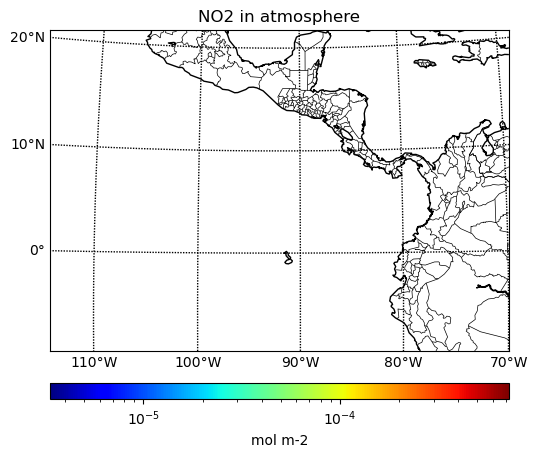

In [12]:
# Plot Data
cs = m.pcolor(xi,yi,np.squeeze(no2),norm=LogNorm(), cmap='jet')

# Add Grid Lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
m.drawstates()
m.drawcountries()

# Add Colorbar
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label(no2_units)

# Add Title
plt.title('NO2 in atmosphere')
plt.show()

# Try it yourself!

#### 1. Open your netCDF file

#### 2. Read your file and print it to see the information

#### 3. Explore different groups within the file

#### 4. Open the PRODUCT group to get dimensions and variables

#### 5. Open the variables and get more information about the data like the shape and convert to a numpy array

#### 6. Get the latitude, longtitude and no2 values

#### 7. Create basemap instance, specifying desired map and projection settings (NOTE: Cartopy library is an alternative to basemap library, and it is being actively developed.You can try using Cartophy library to plot map!!)

#### 8. Plot your data

Note: You can refer to the link below more understanding 

https://joehamman.com/2013/10/12/plotting-netCDF-data-with-Python/ 

There are, of course, many more options and variations to plotting with Maplotlib and Basemap. The [Basemap examples](https://matplotlib.org/basemap/users/examples.html) page includes a nice handful of different plot configurations.

### *Explore similar functions for your other data files!*